## Importando los datos

In [1]:
''' Definimos la funcion para leer el archivo geneX '''
import re
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line = re.sub('["\n]', '', line)
        col=line.split(',')
        data.append(col)
    return data

Al cargar los datos, la variable geneX tendra en su prmer fila (geneX[0]) los datos de los diferenctes momentos a los cuales se tomo la muestra. Luego en la filas subsiguientes (geneX[n]), el primer elemento corresponde al nombre del gen y los demas a los valores de expresion de dicho gen a cada tiempo.

In [2]:
geneX=ldata('geneX.csv')
geneX[500]
#len(geneX)

['AT5G67140',
 '4.58373575111406',
 '2.94259691514112',
 '0.827276383658361',
 '1.24688400499249',
 '1.17370924706566',
 '2.75510867263242',
 '3.83604714379448',
 '2.912978630411',
 '1.13706943028142',
 '1.42537268926943',
 '1.45907758271385',
 '2.84357797142346']

Asignamos los nombres a una lista y los valores a una matriz de numpy, donde las filas corresponden a cada gen y las columnas a cada tiempo.

In [3]:
import numpy as np
valores_genes=np.zeros((500, 12))
nombre_genes=[]
for j in range(1,501):
    nombre_genes.append(geneX[j][0])
    for i in range(1,13):
        valores_genes[j-1,i-1]=float(geneX[j][i])
        
#print(nombre_genes)
print(valores_genes[0])

[ 10.31768664   7.65600446   3.39993568   1.3067949    5.35534801
   9.00846891   9.88520408   7.18594496   3.05035783   1.70774514
   5.1853588    9.02459456]


In [4]:
Corr=np.zeros((500, 500))
mean_genes=[]
for i in range(500):
    mean_genes.append(np.mean(valores_genes[i,:]))
for i in range(500):
    for j in range(500):
        Corr[i,j]=np.sum((valores_genes[i,:]-mean_genes[i])*(valores_genes[j,:]-mean_genes[j]))/np.sqrt((np.sum((valores_genes[i,:]-mean_genes[i])**2)*(np.sum((valores_genes[j,:]-mean_genes[j])**2))))
#print(Corr)

s=(1+Corr)/2
print(s)

Id=np.identity(500)
Ad=s-Id
for i in range(500):
    for j in range(500):
        if Ad[i,j]<0.95:
            Ad[i,j]=0
        else:
            Ad[i,j]=1
print(Ad)



[[ 1.          0.61598957  0.28563361 ...,  0.9435714   0.79372716
   0.94432909]
 [ 0.61598957  1.          0.14070245 ...,  0.5415179   0.34485606
   0.69727414]
 [ 0.28563361  0.14070245  1.         ...,  0.47631711  0.679995
   0.34620371]
 ..., 
 [ 0.9435714   0.5415179   0.47631711 ...,  1.          0.91797449
   0.95214951]
 [ 0.79372716  0.34485606  0.679995   ...,  0.91797449  1.          0.84274472]
 [ 0.94432909  0.69727414  0.34620371 ...,  0.95214951  0.84274472  1.        ]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


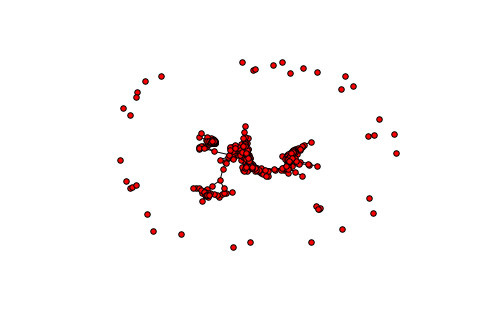

In [7]:
import networkx as nx
G=nx.from_numpy_matrix(Ad)
nx.draw(G, node_size=30)
plt.show()

In [8]:
from networkx.algorithms import community
#from networkx.algorithms.community import greedy_modularity_communities
c = list(nx.algorithms.community.greedy_modularity_communities(G))

## Defininendo funciones

Definimos funciones para calcular infomap y para calcular la modularidad. Para poder calcular comunidades con el metodo infomap, deberan instalar el paqute de igraph para python. Para hacerlo deben abrir una terminal y escribir 'pip3 install --user python-igraph'.

In [9]:
#import igraph as igraph
import networkx as nx
import time

# def calculate_infomap(np_adj_list, method="infomap"):
#     g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
#     t0=time.time()
#     if method=="infomap":
#         labels = g.community_infomap(edge_weights="weight").membership
# #    labels = g.community_label_propagation(weights="weight").membership
#     if method=="fastgreedy":
#         labels = g.community_fastgreedy(edge_weights="weight").membership
   
#     print("Duración: {}s".format(time.time()-t0))
           
#     return labels

from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']


class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.

    Modularity is defined in [1]_ as

    .. math::

        Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)

    where $m$ is the number of edges, $A$ is the adjacency matrix of
    `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$
    is 1 if $i$ and $j$ are in the same community and 0 otherwise.

    Parameters
    ----------
    G : NetworkX Graph

    communities : list
        List of sets of nodes of `G` representing a partition of the
        nodes.

    Returns
    -------
    Q : float
        The modularity of the paritition.

    Raises
    ------
    NotAPartition
        If `communities` is not a partition of the nodes of `G`.

    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.algorithms.community.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704

    References
    ----------
    .. [1] M. E. J. Newman *Networks: An Introduction*, page 224.
       Oxford University Press, 2011.

    """
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm



Probamos la funcion modularity

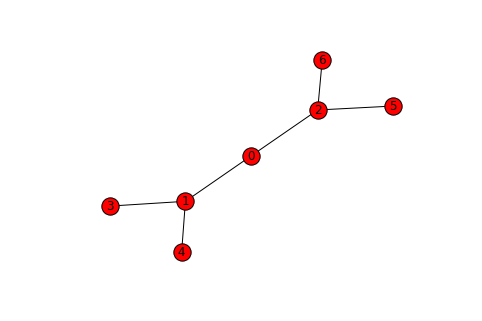

In [10]:
import matplotlib.pyplot as plt
G = nx.balanced_tree(h=2,r=2)
nx.draw(G,with_labels=True)
plt.show()

In [11]:
modularity(G,[[0,1,3,4],[5,2,6]])

0.3194444444444444

In [12]:
modularity(G,[[1,2],[0,4,5,6,3]])

-0.4999999999999996

In [13]:
edges=np.asarray([[0,1,0,0],[1,1,1,1],[0,1,0,1],[1,1,0,0]]) # Matriz de adyacencia
calculate_infomap(edges)

NameError: name 'calculate_infomap' is not defined

Algunos paquetes que les pueden serivr para hacer el dendograma: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [14]:
# For dendogram
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [ ]:
#matriz de correlacion
